In [1]:
from scipy import stats
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import anndata

intersted_genes = ['Trhr','Pdyn','Tacr3','Shox2','Gpr101',]
markergenes = ['Dbh', 'Th', 'Slc6a2']


# get some scripts that are provided in R?

In [2]:
from scipy.stats import rankdata

def normalize_cols(M, ranked=True):
    """
    Normalize the columns of M.
    
    If ranked=True, replace each column with its ranks (using average tie handling).
    Then subtract the mean and divide by the standard deviation.
    
    Parameters:
      M: numpy array of shape (n_samples, n_features)
      ranked: bool, whether to perform ranking.
      
    Returns:
      The normalized matrix.
    """
    result = M.toarray().copy()
    if ranked:  # output shape: 
        result = np.apply_along_axis(rankdata, 0, result)
    means = np.mean(result, axis=0)
    stds = np.std(result, axis=0, ddof=0)
    stds[stds == 0] = 1e-10
    result = (result - means) / stds
    return result


In [58]:
def impute_mer_data(adata_sc, adata_mer, k=10, n_hvg=1000):
    """
    Impute merFISH data (adata_mer) using nearest neighbors from snRNAseq data (adata_sc).

    Parameters:
      adata_sc: AnnData
          snRNAseq data with whole transcriptomics.
      adata_mer: AnnData
          merFISH data with a subset of genes.
      k: int (default=10)
          Number of nearest neighbors to use.
      n_hvg: int (default=1000)
          Number of highly variable genes to select from adata_sc.
          
    Returns:
      An AnnData object with imputed expression for the union gene set.
    """
    adata_sc = adata_sc.copy()  # work on a copy to avoid modifying the original data
    if n_hvg is not None:
        sc.pp.highly_variable_genes(adata_sc, n_top_genes=n_hvg, flavor='seurat_v3')
        hvg_genes = adata_sc.var_names[adata_sc.var['highly_variable']]
    else:
        hvg_genes = adata_sc.var_names
    
    union_genes = np.union1d(hvg_genes, adata_mer.var_names)  # 1183    
    observed_genes = np.array(adata_mer.var_names)
    adata_sc_union = adata_sc[:, union_genes].copy()  # we will impute based on this guy, 1183 genes in total     
    common_genes = np.intersect1d(adata_mer.var_names, union_genes)
    
    X_sc = adata_sc_union[:, common_genes].X  # reference (snRNAseq) matrix, shape: (5000, len(common_genes))
    X_mer = adata_mer[:, common_genes].X       # query (merFISH) matrix, shape: (3000, len(common_genes))
    
    #  scale/normalize these matrices further.)    
    X_sc_norm = normalize_cols(X_sc, ranked=True)
    X_mer_norm = normalize_cols(X_mer, ranked=True)
        
    # Step 6. Find k nearest neighbors for each merFISH cell from the snRNAseq data.
    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(X_sc_norm)
    distances, indices = nbrs.kneighbors(X_mer_norm) # distance: size (3227, K)
    
    epsilon = 1e-10
    weights = 1 / (distances + epsilon)  # (N_merfish, K)
    weights = weights / weights.sum(axis=1, keepdims=True)  # normalize so that weights sum to 1
    
    # Step 8. Impute gene expressions for each merFISH cell.
    # For each cell, the imputed expression of a gene is the weighted average of that gene's expression
    # in the k nearest snRNAseq cells.
    imputed_expr = np.zeros((adata_mer.n_obs, len(union_genes)))
    for i in range(adata_mer.n_obs):
        neighbor_idx = indices[i]
        imputed_expr[i, :] = np.dot(weights[i], adata_sc_union.X[neighbor_idx, :].toarray())  # 10, (10, 314)
    
    # does this even make sens?
    observed_idx = [i for i, gene in enumerate(union_genes) if gene in observed_genes]
    original_expr = np.zeros((adata_mer.n_obs, len(observed_idx)))
    for j, idx in enumerate(observed_idx):
        gene = union_genes[idx]
        # Since gene is in adata_mer.var_names, we can retrieve its column directly.
        col = np.where(adata_mer.var_names == gene)[0][0]
        original_expr[:, j] = adata_mer.X[:, col].toarray().flatten() if hasattr(adata_mer.X, "toarray") else adata_mer.X[:, col]
    
    # Insert the original expression values for the observed genes.
    imputed_expr[:, observed_idx] = (original_expr)

    # Create a new AnnData with the updated matrix and union_genes as var names.
    adata_mer_imputed = anndata.AnnData(
        X=imputed_expr,
        obs=adata_mer.obs.copy(),
        var=pd.DataFrame(index=union_genes)
    )
    
    return adata_mer_imputed



In [30]:
adata_mer.X.max()

np.float64(13.212516301983163)

In [31]:
adata_sc.X.max()

np.float64(8.70200566298779)

# load data

In [4]:
import glob, os
from scipy.io import mmread


In [5]:

filepath = '/allen/aind/scratch/shuonan.chen/LC_scRNAseq/conversion_files/'
f = glob.glob(filepath+'/*.h5ad')[1]
dataname = os.path.basename(f).split('.')[0]
targetfile = filepath + f'{dataname}.h5ad'    
targetfile_raw = filepath + f'RNA_counts_{dataname}.mtx'
adata_sc = sc.read_h5ad(targetfile)
adata_sc.layers['rawcounts'] = mmread(targetfile_raw).transpose().tocsr().astype('float64')    
adata_sc.X = adata_sc.layers['rawcounts']  
adata_sc.obs['sex'] = adata_sc.obs['sex'].replace({'M;M;M;M;M;M;M;M;M;M': 'M', 'F;F;F;F;F;F;F;F;F;F': 'F'})

/scratch/fast/19664/ipykernel_2408549/2000313053.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_sc.obs['sex'] = adata_sc.obs['sex'].replace({'M;M;M;M;M;M;M;M;M;M': 'M', 'F;F;F;F;F;F;F;F;F;F': 'F'})


In [6]:
adata_sc.var["mt"] = adata_sc.var_names.str.startswith(("MT-","mt-"))
adata_sc.var["ribo"] = adata_sc.var_names.str.startswith(("RPS", "RPL",'rps','rpl'))
adata_sc.var["hb"] = adata_sc.var_names.str.contains("^HB[^(P)]")

print(adata_sc.var['mt'].sum(), adata_sc.var['ribo'].sum(), adata_sc.var['hb'].sum())

13 0 0


In [7]:
sc.pp.calculate_qc_metrics(
    adata_sc, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


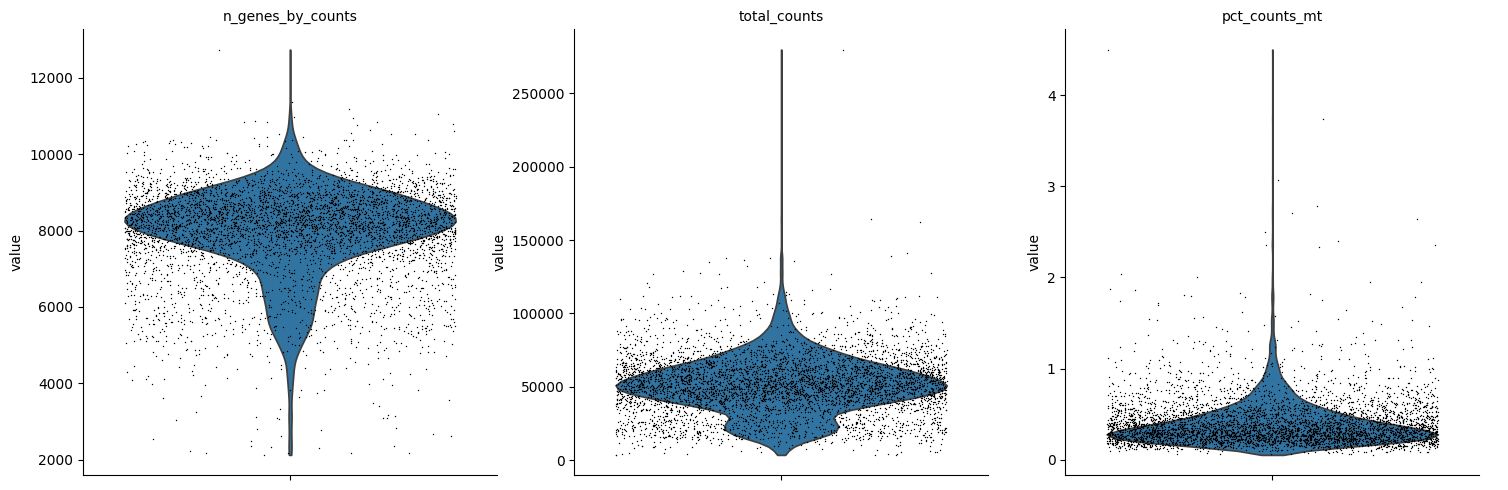

In [8]:
sc.pl.violin(
    adata_sc,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


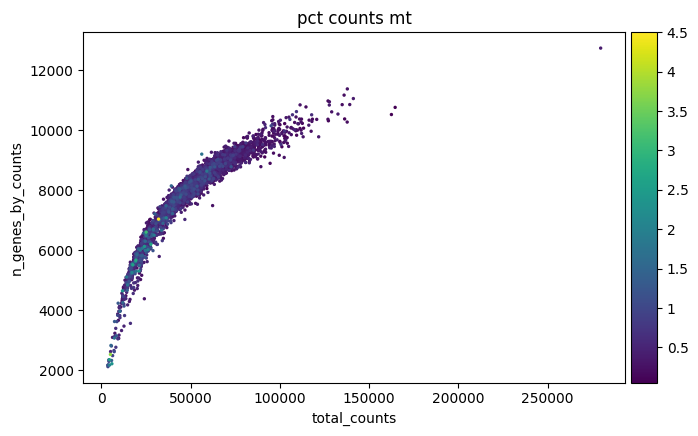

In [9]:
sc.pl.scatter(adata_sc, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [10]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)

# load merfish too
(these are normalized already..?)

In [11]:
filename = '/allen/aind/scratch/shuonan.chen/code/pons_merfish_pipeline/processing/adata_mer_subset_3k.h5ad'
adata_mer = sc.read_h5ad(filename)
var_names = adata_mer.var_names.intersection(adata_sc.var_names)
adata_mer = adata_mer[:,var_names]  # 314 genes 

In [12]:
adata_mer.shape

(3227, 314)

In [13]:
sc.pl.umap(adata_mer, color=['leiden',], )


### re-run the leiden for these 3k cells

In [14]:
sc.tl.pca(adata_mer)
sc.pp.neighbors(adata_mer)
sc.tl.umap(adata_mer, random_state=210)
sc.tl.leiden(adata_mer, resolution=1, key_added = 'new leiden!', random_state=224) 

/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/scratch/fast/19664/ipykernel_2408549/504708503.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_mer, resolution=1, key_added = 'new leiden!', random_state=224)


In [15]:
sc.pl.umap(adata_mer,color=['leiden', 'new leiden!',"Dbh"]+intersted_genes,cmap='Reds',ncols=3)

In [16]:
adata_mer.shape, adata_sc.shape

((3227, 314), (5040, 29617))

In [59]:

adata_mer_imputed = impute_mer_data(adata_sc, adata_mer, k=20, n_hvg=None)

# okay now we run teh clustering kind of thing

In [50]:
adata_mer_imputed.var_names

Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009L18Rik', '0610010F05Rik', '0610010K14Rik', '0610012D04Rik',
       '0610012G03Rik', '0610025J13Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=29617)

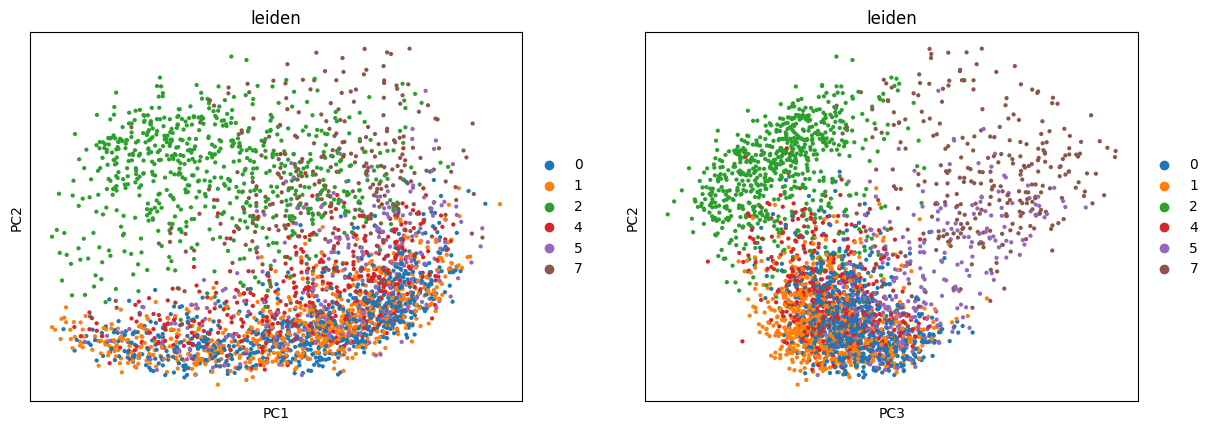

In [60]:
sc.tl.pca(adata_mer_imputed)
sc.pl.pca(adata_mer_imputed,color=['leiden','leiden'], dimensions = [(0,1),(2,1)])

In [61]:
adata_mer_imputed.varm

AxisArrays with keys: PCs

In [62]:
df_loadings = pd.DataFrame(adata_mer_imputed.varm['PCs'], index=adata_mer_imputed.var_names)

In [63]:
# top T genes with PC1.. 

T = 10
adata_mer_imputed.var_names[np.argsort(df_loadings[0])[::-1][:T]]  

Index(['Ghr', 'Snap25', 'Cnr1', 'Piezo2', 'Gsg1l', 'Gabrg1', 'Galntl6', 'Npr3',
       'Gpr156', 'Aifm3'],
      dtype='object')

In [64]:
adata_mer_imputed.shape

(3227, 29617)

In [67]:
adata_mer.X.max()

np.float64(13.212516301983163)

In [68]:
adata_sc.X.max()

np.float64(8.70200566298779)

In [76]:
import matplotlib.pyplot as plt

In [81]:
(adata_mer.X[:,adata_mer.var_names =='Dbh'] == adata_mer_imputed.X[:,adata_mer_imputed.var_names =='Dbh']).all()

np.True_

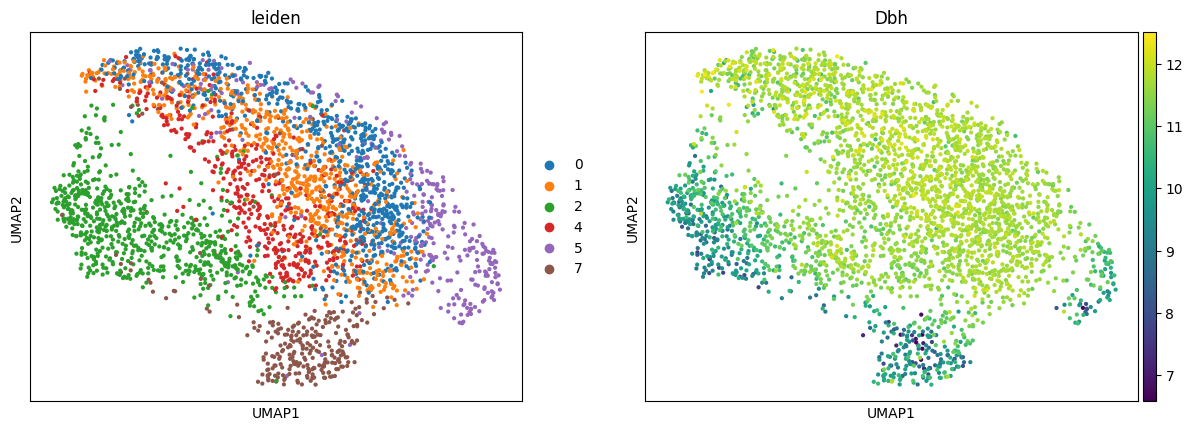

In [65]:

sc.pp.neighbors(adata_mer_imputed)
sc.tl.umap(adata_mer_imputed)
sc.pl.umap(adata_mer_imputed,color=["leiden",'Dbh'],)

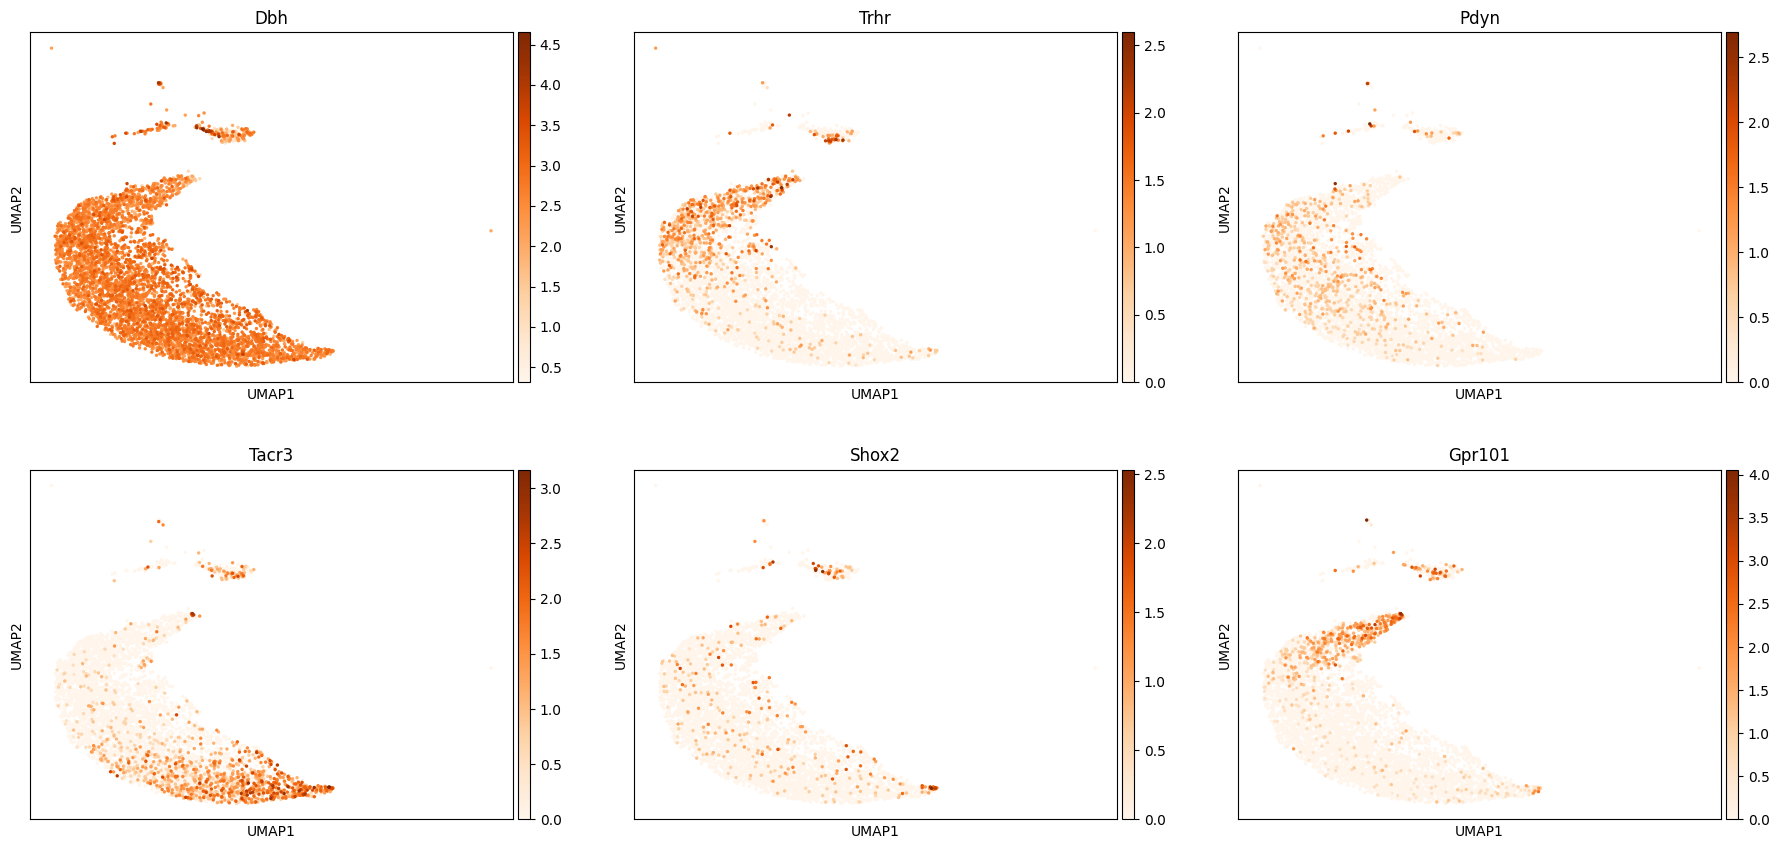

In [85]:
sc.pl.umap(adata_sc,color=["Dbh"]+intersted_genes,
           cmap='Oranges',ncols=3)

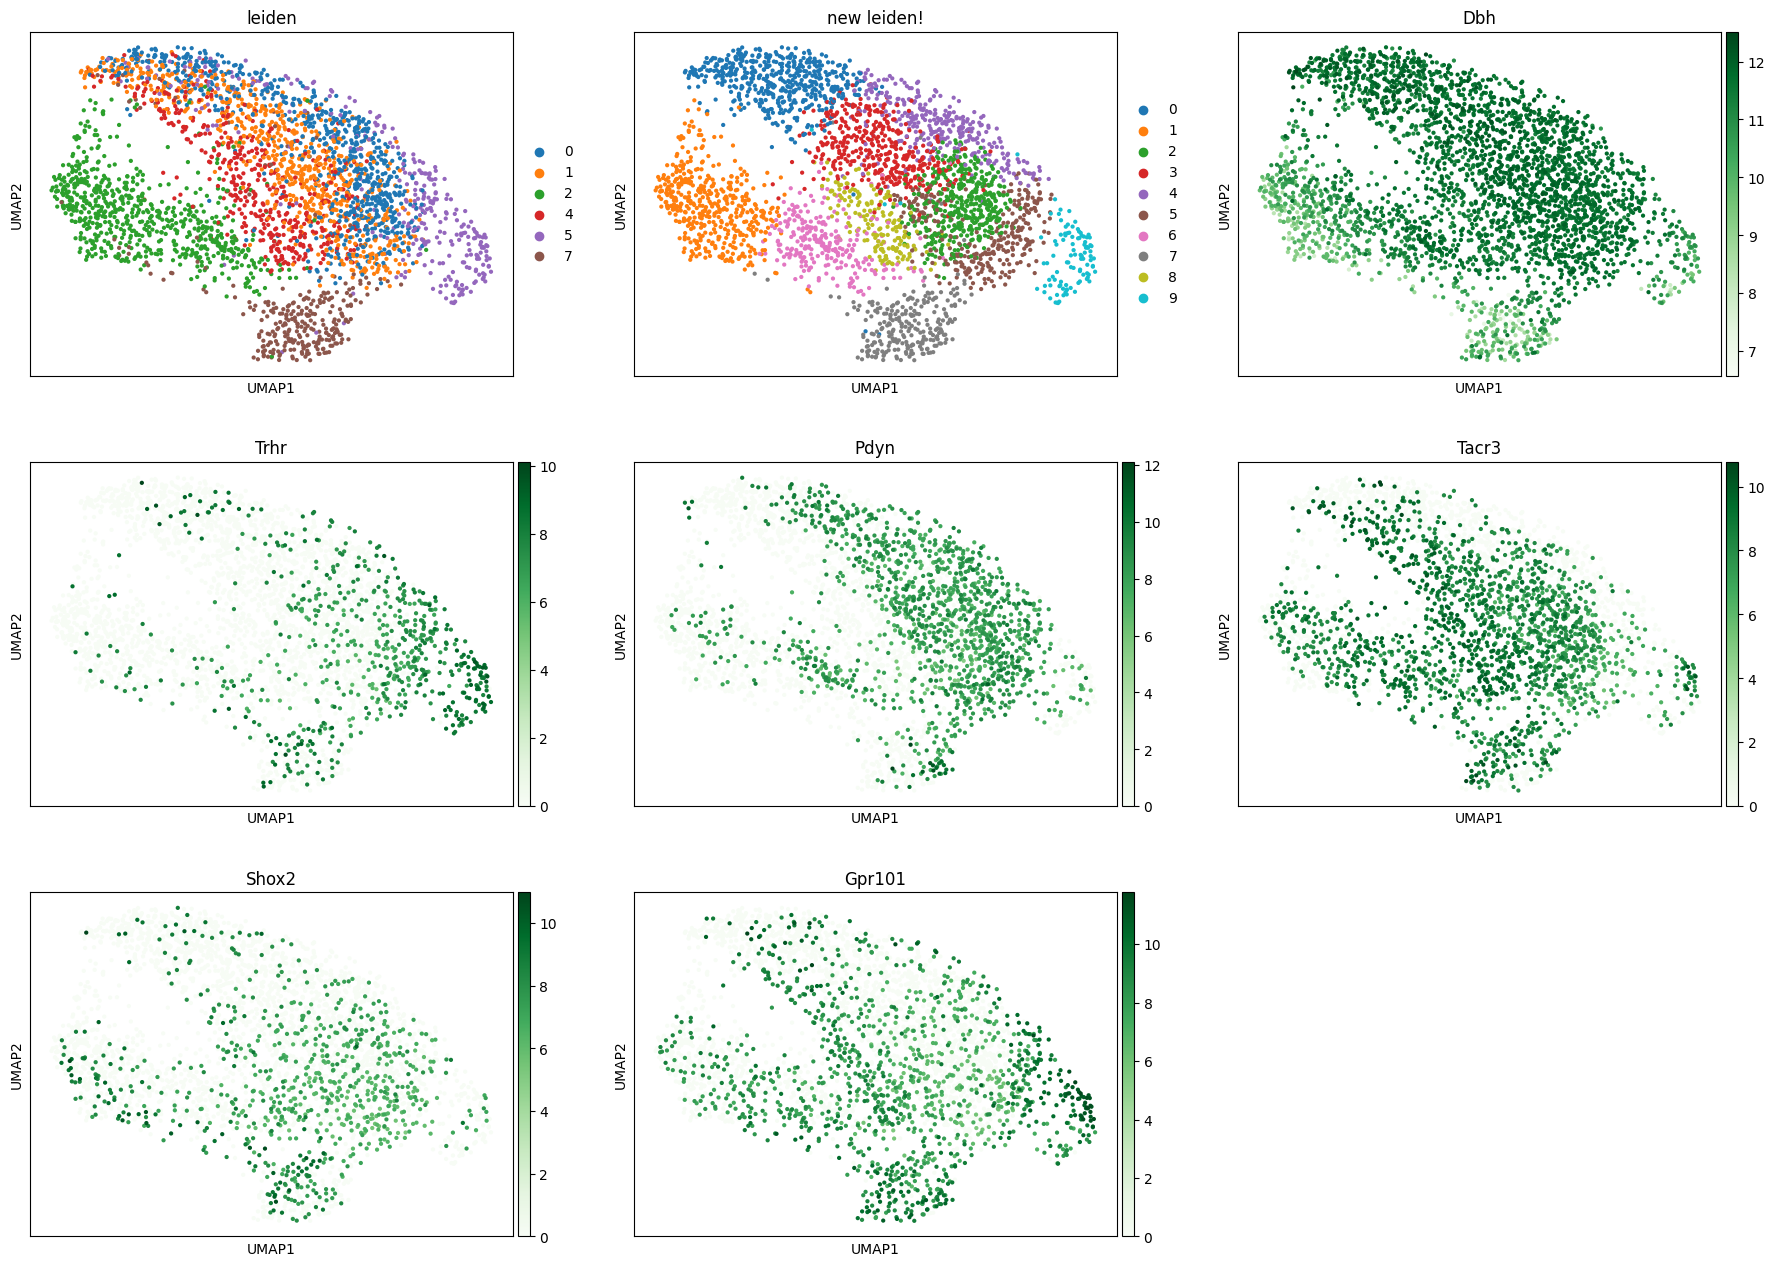

In [66]:
sc.pl.umap(adata_mer_imputed,color=['leiden', 'new leiden!',"Dbh"]+intersted_genes,
           cmap='Greens',ncols=3)

## todo: we need to make sure that 314 pre-existing genes are NOT imputed..

In [42]:
g_sel = adata_mer.var_names[10]
print(g_sel)

Adcyap1


Text(0, 0.5, 'imputed')

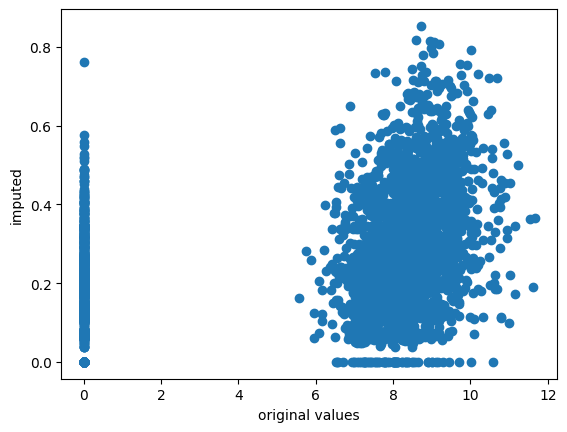

In [92]:
import matplotlib.pyplot as plt
plt.scatter((adata_mer[:,g_sel].X), (adata_mer_imputed[:,g_sel].X))
plt.xlabel('original values')
plt.ylabel('imputed')

# so how to validate this imputation result? 

we cannot check teh gradient genes at this point because these are not imputed. 

1. run scvi on them, and re-plot the umap